In [1]:
# Loading required libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the data:
pump = pd.read_csv("/home/mozhdeh/Desktop/the_project_codes/project_pump.csv", error_bad_lines=False, sep='[;,]', header=None, engine = 'python')

In [3]:
# Having the plots inline:
%matplotlib inline

In [5]:
# Dropping the first columns, only keeping sensor data:
pump.drop([0,1,2,3,4,16387],axis=1, inplace=True)
pump.reset_index(drop=True, inplace=True)

/home/mozhdeh/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


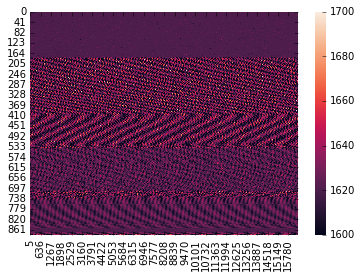

In [6]:
# Having a look on data, we see there are visually 5 states visible for the pump machine:
sns.heatmap(pump, vmin=1600, vmax=1700)

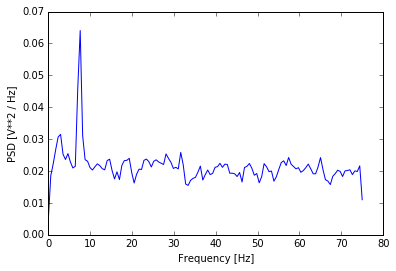

In [57]:
# to calculate the Power Spectrum Density for each state of pump vibrations, as an example we see the power spectrum
# for the 500th row here. If we check the PSD for other states, we see that the PSD peaks are different for different
# states!
from scipy.signal import welch
 
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values
 
t_n =1
N = 150
T = t_n / N
f_s = 1/T # The sampling frequency must be > 2*Nyquist Freq.
 
f_values, psd_values = get_psd_values(pump.iloc[100,:], T, N, f_s)
 
plt.plot(f_values, psd_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2 / Hz]')
plt.show()

In [9]:
#Now we want to detect peaks of the power spectrum, using a function called detect_peaks:

In [58]:
from detect_peaks import detect_peaks

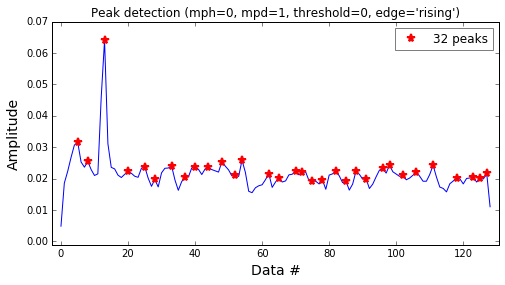

array([  5,   8,  13,  20,  25,  28,  33,  37,  40,  44,  48,  52,  54,
        62,  65,  70,  72,  75,  78,  82,  85,  88,  91,  96,  98, 102,
       106, 111, 118, 123, 125, 127])

In [59]:
detect_peaks(psd_values, mph=0, mpd=1, show=True)

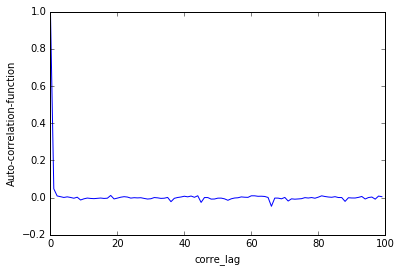

In [60]:
# One can calculate the Auto-correlation Function (ACF) as well, which is the fft of PSD (in frequency domain the 
# peaks are the same):
laggmax = 100
corFunc = np.zeros(laggmax,dtype=float)

for lagg in range(0, 100):
    corFunc[lagg] = pump.iloc[100,:].autocorr(lag=lagg)

plt.plot(corFunc, linewidth = 1.0)
plt.xlabel('corre_lag')
plt.ylabel('Auto-correlation-function')

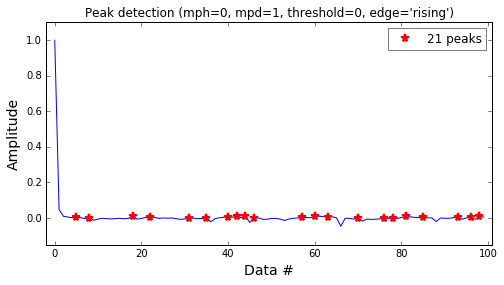

array([ 5,  8, 18, 22, 31, 35, 40, 42, 44, 46, 57, 60, 63, 70, 76, 78, 81,
       85, 93, 96, 98])

In [61]:
detect_peaks(corFunc, mph=0, mpd=1, show=True)

In [14]:
# Now I want to lable each state of the machine in a new column label (I have done it visually):

pump['state_label'] = pump[100] + pump[100]

for i in range(0,883):
    for i in range(0,200):
        pump['state_label'][i]=1    
    for i in range(200,400):
         pump['state_label'][i]=2
    for i in range(400,530):
         pump['state_label'][i]=3
    for i in range(530,700): 
         pump['state_label'][i]=4
    for i in range(700,882):
         pump['state_label'][i]=5
            

In [15]:
# The training set:
train_signals = pd.concat([pump.iloc[0:100,:], pump.iloc[200:300,:], pump.iloc[400:500,:],pump.iloc[550:650,:],pump.iloc[700:800,:]], axis=0)
train_labels = pd.concat([pump['state_label'][0:100], pump['state_label'][200:300], pump['state_label'][400:500],pump['state_label'][550:650],pump['state_label'][700:800]], axis=0)


In [16]:
# The test set:
test_signals = pd.concat([pump.iloc[100:150,:], pump.iloc[300:350,:], pump.iloc[500:550,:], pump.iloc[650:700,:], pump.iloc[800:850,:]],axis=0, ignore_index=True) 
test_labels = pd.concat([pump['state_label'][100:150], pump['state_label'][300:350], pump['state_label'][500:550], pump['state_label'][650:700], pump['state_label'][800:850]],axis=0, ignore_index=True)



In [44]:
# ignoring the former indexing:
train_signals.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
test_signals.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)


In [ ]:
#del train_signals['state_label']
#del test_signals['state_label']
train_labels = pd.DataFrame(train_labels)
test_labels = pd.DataFrame(test_labels)

In [54]:
# Here I intend to get the firat number of peaks and get the x and y as the features and then use it as the train and
# test sets:

def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) > no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

def extract_features_labels(dataset, labels, T, N, f_s):
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        signal = dataset[signal_no, :]
            
        features += get_features(*get_psd_values(signal, T, N, f_s), mph)
        #features += get_features(*get_fft_values(signal, T, N, f_s), mph)
        #features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
        return np.array(list_of_features), np.array(list_of_labels)


In [55]:
t_n = 340/1000
N = 16384
T = t_n/N
f_s = 1/T

X_train, Y_train = extract_features_labels(train_signals, train_labels, T, N, f_s)
X_test, Y_test = extract_features_labels(test_signals, test_labels, T, N, f_s)

KeyError: 0

In [ ]:
# Now we want to train a random forest classifier based on labels and features:

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

NameError: name 'X_train' is not defined